# Import all the library

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Load and merge the data set

In [67]:
# Load the tables
email_df = pd.read_csv('email_table.csv')
opened_df = pd.read_csv('email_opened_table.csv')
clicked_df = pd.read_csv('link_clicked_table.csv')

# Add opened and clicked flags cols .
email_df['email_opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['link_clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

In [68]:
email_df

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_opened,link_clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0
...,...,...,...,...,...,...,...,...,...
99995,803504,short_email,personalized,4,Monday,US,5,0,0
99996,899722,long_email,personalized,7,Saturday,US,1,0,0
99997,449610,long_email,personalized,11,Saturday,UK,6,0,0
99998,72497,short_email,generic,10,Monday,UK,0,0,0


# Overall Campaign Performance

In [69]:
open_rate = email_df['email_opened'].mean() * 100
click_rate = email_df['link_clicked'].mean() * 100

print(f" Open Rate: {open_rate:.2f}%")
print(f"Click Rate: {click_rate:.2f}%")


 Open Rate: 10.35%
Click Rate: 2.12%


In [70]:
email_df.shape

(100000, 9)

In [71]:
email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
 7   email_opened         100000 non-null  int64 
 8   link_clicked         100000 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 6.9+ MB


In [72]:
email_df.describe()

,email_id,hour,user_past_purchases,email_opened,link_clicked
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,498690.196160,9.059300,3.87845,0.103450,0.021190
std,289230.727534,4.439637,3.19611,0.304547,0.144018
min,8.000000,1.000000,0.00000,0.000000,0.000000
25%,246708.250000,6.000000,1.00000,0.000000,0.000000
50%,498447.000000,9.000000,3.00000,0.000000,0.000000
75%,749942.750000,12.000000,6.00000,0.000000,0.000000
max,999998.000000,24.000000,22.00000,1.000000,1.000000


In [73]:
email_df.isnull().sum()

,0
email_id,0
email_text,0
email_version,0
hour,0
weekday,0
user_country,0
user_past_purchases,0
email_opened,0
link_clicked,0


#EDA

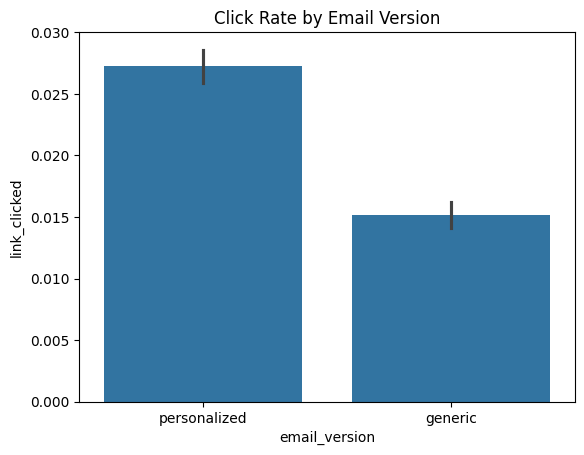

In [74]:
sns.barplot(data=email_df, x='email_version', y='link_clicked')
plt.title('Click Rate by Email Version')
plt.show()

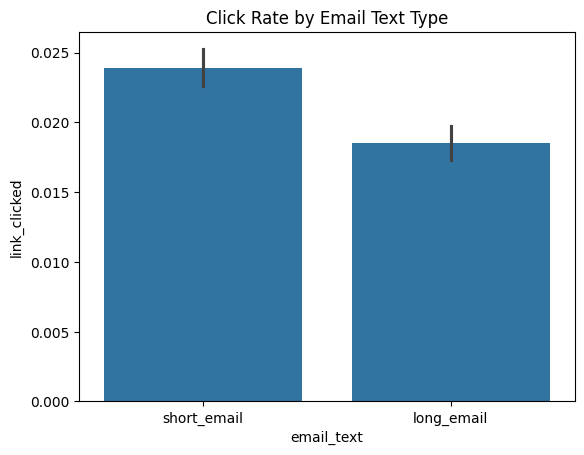

In [75]:
# CTR by email text
sns.barplot(data=email_df, x='email_text', y='link_clicked')
plt.title('Click Rate by Email Text Type')
plt.show()

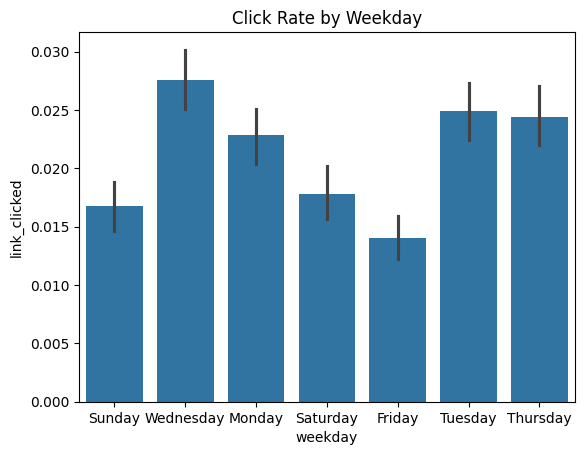

In [76]:
# CTR by weekday
sns.barplot(data=email_df, x='weekday', y='link_clicked')
plt.title('Click Rate by Weekday')
plt.show()

# Build a Predictive Model for Clicks

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Preprocessing
df_model = email_df.copy()
df_model = pd.get_dummies(df_model, columns=['email_text', 'email_version', 'weekday', 'user_country'], drop_first=True)

X = df_model.drop(columns=['email_id', 'email_opened', 'link_clicked'])
y = df_model['link_clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19576
           1       0.07      0.01      0.02       424

    accuracy                           0.98     20000
   macro avg       0.53      0.50      0.50     20000
weighted avg       0.96      0.98      0.97     20000

ROC-AUC Score: 0.5793647255784903


In [78]:
df_model['predicted_prob'] = clf.predict_proba(X)[:,1]
top_users = df_model.sort_values(by='predicted_prob', ascending=False).head(len(email_df))
new_ctr = top_users['link_clicked'].mean() * 100
baseline_ctr = click_rate

print(f" Baseline CTR: {baseline_ctr:.2f}%")
print(f"Optimized CTR (Simulated): {new_ctr:.2f}%")
print(f"CTR Improvement: {new_ctr - baseline_ctr:.2f}%")


 Baseline CTR: 2.12%
Optimized CTR (Simulated): 2.12%
CTR Improvement: 0.00%


In [79]:
segment_stats = email_df.groupby('user_country')[['email_opened', 'link_clicked']].mean().sort_values(by='link_clicked', ascending=False)
print("\nTop Performing Countries by CTR:")
print(segment_stats.head())



Top Performing Countries by CTR:
              email_opened  link_clicked
user_country                            
UK                0.120167      0.024675
US                0.119020      0.024360
ES                0.039129      0.008327
FR                0.040620      0.008004


# Try Diff- diff ML Algo

In [80]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"\n {name} Performance")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_score:.4f}")

models = [
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (GradientBoostingClassifier(n_estimators=100), "Gradient Boosting"),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), "XGBoost"),
    (MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42), "Neural Network")
]

for model, name in models:
    evaluate_model(model, name)

# -------------------------------
# Step 6: Simulate Optimized Campaign (using best model)

best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train, y_train)
email_df['predicted_prob'] = best_model.predict_proba(X)[:,1]
top_users = email_df.sort_values(by='predicted_prob', ascending=False).head(len(email_df))
new_ctr = top_users['link_clicked'].mean() * 100

print(f"\n Baseline CTR: {click_rate:.2f}%")
print(f"Optimized CTR (Simulated): {new_ctr:.2f}%")
print(f"CTR Improvement: {new_ctr - click_rate:.2f}%")



 Logistic Regression Performance
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19576
           1       0.00      0.00      0.00       424

    accuracy                           0.98     20000
   macro avg       0.49      0.50      0.49     20000
weighted avg       0.96      0.98      0.97     20000

ROC-AUC Score: 0.7351


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 Random Forest Performance
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19576
           1       0.07      0.01      0.02       424

    accuracy                           0.98     20000
   macro avg       0.53      0.50      0.50     20000
weighted avg       0.96      0.98      0.97     20000

ROC-AUC Score: 0.5794

 Gradient Boosting Performance
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19576
           1       0.00      0.00      0.00       424

    accuracy                           0.98     20000
   macro avg       0.49      0.50      0.49     20000
weighted avg       0.96      0.98      0.97     20000

ROC-AUC Score: 0.7461


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:25:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 XGBoost Performance
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19576
           1       0.00      0.00      0.00       424

    accuracy                           0.98     20000
   macro avg       0.49      0.50      0.49     20000
weighted avg       0.96      0.98      0.97     20000

ROC-AUC Score: 0.7173

 Neural Network Performance
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19576
           1       0.00      0.00      0.00       424

    accuracy                           0.98     20000
   macro avg       0.49      0.50      0.49     20000
weighted avg       0.96      0.98      0.97     20000

ROC-AUC Score: 0.7320


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:26:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Baseline CTR: 2.12%
Optimized CTR (Simulated): 2.12%
CTR Improvement: 0.00%



# XGBoost - Feature Importance

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:26:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x600 with 0 Axes>

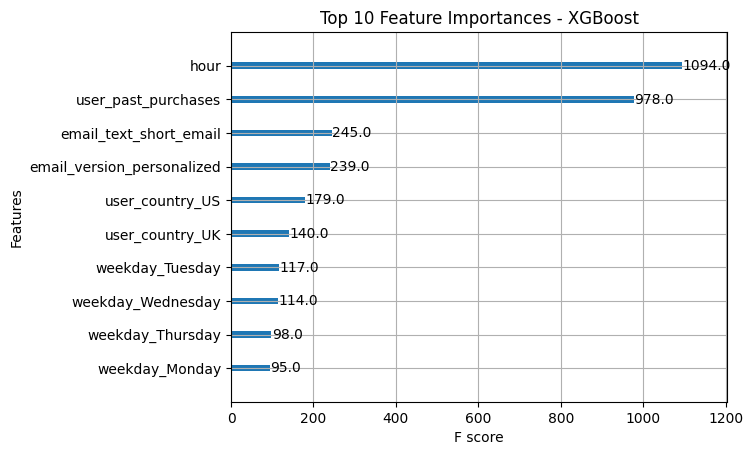

In [81]:
# Step 6: XGBoost - Feature Importance
!pip install xgboost
from xgboost import XGBClassifier, plot_importance # Import plot_importance

xgb_best = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_best.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=10) # Now plot_importance is defined and can be used
plt.title('Top 10 Feature Importances - XGBoost')
plt.show()


#Step 7: Hyperparameter Tuning (Grid Search)

In [82]:
grid_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
}

grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), grid_params,
                           cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\n📊 Best Parameters from Grid Search:")
print(grid_search.best_params_)
print(f"Best ROC-AUC: {grid_search.best_score_:.4f}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:27:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Best Parameters from Grid Search:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best ROC-AUC: 0.7424
